In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_normal
from scipy.sparse import spdiags
from scipy.sparse import kron
from mpl_toolkits.mplot3d import Axes3D
import time

Create a Mixture Multivariate Gaussian Distribution as the truth:
$$\rho ^* = 0.3N(\mu_1, I) + 0.7N(\mu_2, I)$$
where $\mu_1 = [1, 3]^T$ and $\mu_2 = [3, 2]^T$

In [41]:
##define the truth pdf:
mu1 = np.array([1, 3]); mu2 = np.array([3, 2]);

def truth(x):
    y1 = multivariate_normal.pdf(x, mean=np.array([1, 3]), cov=[[1, 0], [0, 1]])
    y2 = multivariate_normal.pdf(x, mean=np.array([3, 2]), cov=[[1, 0], [0, 1]])
    return 0.3*y1 + 0.7*y2;

##define our model function
def model(x, w, mu1, mu2):
    y1 = multivariate_normal.pdf(x, mean=mu1, cov=[[1, 0], [0, 1]])
    y2 = multivariate_normal.pdf(x, mean=mu2, cov=[[1, 0], [0, 1]])
    return w*y1 + (1-w)*y2;

##define our 31*31 grid points:
dx = 5/31; dy = 5/31;
X = [];
for i in range(1, 31):
    for j in range(1, 31):
        X.append([dx*i, dy*j]);
X = np.array(X);
ytruth = truth(X);


Our model: (assuming identity covariance matrix)
$$\rho(x, w, \mu_1, \mu_2) = w\frac{1}{2\pi} exp\{-\frac{1}{2}(x-\mu_1)^T(x-\mu_1)\}  + (1-w)\frac{1}{2\pi} exp\{-\frac{1}{2}(x-\mu_2)^T(x-\mu_2)\}$$
The derivative with respect to $w$:
$$\frac{d\rho}{dw} = \frac{1}{2\pi} exp\{-\frac{1}{2}(x-\mu_1)^T(x-\mu_1)\} -\frac{1}{2\pi} exp\{-\frac{1}{2}(x-\mu_2)^T(x-\mu_2)\}$$
The derivative with respect to $\mu_1$:
$$\frac{d\rho}{d\mu_1} = -w\frac{1}{2\pi}(\mu_1 - x)exp\{-\frac{1}{2}(x-\mu_1)^T(x-\mu_1)\}$$
The derivative with respect to $\mu_2$:
$$\frac{d\rho}{d\mu_2} = (w-1)\frac{1}{2\pi}(\mu_2 - x)exp\{-\frac{1}{2}(x-\mu_2)^T(x-\mu_2)\}$$

$$\frac{d\rho}{d\mu_{11}} = -\frac{w}{2\pi}(x_1 - \mu_{11})exp\{-\frac{1}{2}(x-\mu_1)^T(x-\mu_1) \}$$
This model as 3 parameters, with a total dimension of 5.

In [10]:
def expinner(x, mu):
    inner = -0.5*np.einsum("ij, ij->i", x-mu, x-mu);
    return np.exp(inner);  

#the derivative dp/dw:
def dpdw(x, mu1, mu2):
    a = (1/(2*np.pi))*expinner(x, mu1);
    b = (1/(2*np.pi))*expinner(x, mu2);
    return a-b;

#the derivative dp/dmu1:
def dpdmu1(w, x, mu1):
    t1 = expinner(x, mu1); t2 = (mu1-x);
    return -w*(1/(2*np.pi))*np.multiply(t2, t1[:, np.newaxis]);
    
#the derivative dp/dmu2:
def dpdmu2(w, x, mu2):
    t1 = expinner(x, mu2); t2 = (mu2-x);
    return (w-1)*(1/(2*np.pi))*np.multiply(t2, t1[:, np.newaxis]);

The loss function:
$$U(\theta) = \sum_{i=1}^N \frac{1}{2}|| \rho^*(x_i)-\rho(x_i, \theta) ||^2_2$$
Its derivative w.r.t w:
$$\frac{dU}{dw} = \sum_{i=1}^N [\frac{d}{dw} (\frac{1}{2}|| \rho^*(x_i)-\rho(x_i, \theta)||^2_2)]$$
$$= \sum_{i=1}^N \{ (\rho(x_i, \theta)-\rho^*(x_i))\frac{d\rho}{dw}(x_i, \theta) \}$$
Its derivative w.r.t $\mu_j$, j=1, 2:
$$\frac{dU}{d\mu_j} = \sum_{i=1}^N \{ (\rho(x_i, \theta)-\rho^*(x_i))\frac{d\rho}{d\mu_j}(x_i, \theta)  \}$$

In [11]:
#the loss function
def loss(X, w, mu1, mu2):
    truthvalue = truth(X);
    modelvalue = model(X, w, mu1, mu2);
    result = 0.5*(truthvalue-modelvalue)**2;
    return np.sum(result);

In [12]:
#compute the derivative dUdw:
#inputs are: dataset X, parameters w, mu1, mu2
def dudw(X, w, mu1, mu2):
    p = model(X, w, mu1, mu2) - ytruth;
    dw = dpdw(X, mu1, mu2);
    return np.inner(p, dw);

#compute the derivative dUdmu1:
def dudmu1(X, w, mu1, mu2):
    p = model(X, w, mu1, mu2) - ytruth;
    dmu = dpdmu1(w, X, mu1);
    list1 = np.multiply(dmu, p[:, np.newaxis]);
    return np.sum(list1, axis=0);

#compute the derivative dUdmu2:
def dudmu2(X, w, mu1, mu2):
    p = model(X, w, mu1, mu2) - ytruth;
    dmu = dpdmu2(w, X, mu2);
    list2 = np.multiply(dmu, p[:, np.newaxis]);
    return np.sum(list2, axis=0);

def gradient(X, w, mu1, mu2):
    dw = dudw(X, w, mu1, mu2);
    dmu1 = dudmu1(X, w, mu1, mu2);
    dmu2 = dudmu2(X, w, mu1, mu2);
    return np.array([dw, dmu1[0], dmu1[1], dmu2[0], dmu2[1]]);

##it returns the gradient of p and gradient of U together
def gradient_all(X, w, mu1, mu2):
    p = model(X, w, mu1, mu2) -ytruth;
    dpw = dpdw(X, mu1, mu2);
    dpmu1 = dpdmu1(w, X, mu1);
    dpmu2 = dpdmu2(w, X, mu2);
    P = np.array([dpw, dpmu1[:, 0], dpmu1[:, 1], dpmu2[:, 0], dpmu2[:, 1]]);
    duw = np.inner(p, dpw);
    dumu1 = np.sum(np.multiply(dpmu1, p[:, np.newaxis]), axis=0);
    dumu2 = np.sum(np.multiply(dpmu2, p[:, np.newaxis]), axis=0);
    Q = np.array([duw, dumu1[0], dumu1[1], dumu2[0], dumu2[1]]);
    return [P, Q];

In [13]:
##this function returns the gradient of p and U w.r.t mu1 only
def gradient_mu1_all(X, w, mu1, mu2):
    p = model(X, w, mu1, mu2) - ytruth;
    dpmu1 = dpdmu1(w, X, mu1);
    Q = np.sum(np.multiply(dpmu1, p[:, np.newaxis]), axis=0);
    return [dpmu1, Q];

Implement the gradient descent algorithm:
$$\theta^{(n+1)} = \theta^{(n)} -\eta_n \nabla_{\theta}U(\theta)$$

In [14]:
##constant grid
##this is the grid that is used to plot the loss function 
grid = 0.2;

##it plots the loss function with fixed w, mu2
##it also plots the convergence history of mu1 given the trace and tracevalue paras
def plot_loss_mu1(X, w, mu2, grid, xrange, yrange, trace, tracevalue):
    x = np.arange(xrange[0],xrange[1],grid);
    y = np.arange(yrange[0],yrange[1],grid);
    P,Q = np.meshgrid(x,y)
    Z = np.zeros((x.size, y.size));
    print(P.shape);print(Q.shape); print(Z.shape)
    for i in range(x.size):
        for j in range(y.size):
            Z[i, j] = loss(X, w, np.array([grid*i+xrange[0], grid*j+yrange[0]]), mu2);
    fig = plt.figure(figsize=(12, 8));
    axes = fig.gca(projection ='3d');
    axes.view_init(elev=50, azim=10);
    axes.plot(trace[:,1], trace[:,0], tracevalue, '*-', c = 'red')
    axes.plot_surface(P, Q, Z, alpha = 0.8);
    print(trace.shape);
    print(tracevalue.shape);
    plt.show();
    fig, ax = plt.subplots(figsize=(12, 12));
    level = np.arange(0, 0.5, 0.015);
    CS = ax.contour(Q,P,Z,levels = level);
    ax.clabel(CS, inline=True, fontsize=10);
    ax.plot(trace[:, 0], trace[:, 1], "*-", c='red');
    ax.set_title('Loss Function w.r.t mu1')
    
def plot_loss_mu2(X, w, mu1, grid, xrange, yrange, trace, tracevalue):
    x = np.arange(xrange[0],xrange[1],grid);
    y = np.arange(yrange[0],yrange[1],grid);
    P,Q = np.meshgrid(x,y)
    Z = np.zeros((x.size, y.size));
    for i in range(x.size):
        for j in range(y.size):
            Z[i, j] = loss(X, w, mu1, np.array([grid*i+xrange[0], grid*j+yrange[0]]));
    fig = plt.figure(figsize=(12, 8));
    axes = fig.gca(projection ='3d');
    axes.view_init(elev=50, azim=10);
    axes.scatter(trace[:,1], trace[:,0], tracevalue, '*-' ,c = 'red')
    axes.plot_surface(P, Q, Z, alpha = 0.8);
    print(trace.shape);
    print(tracevalue.shape);
    plt.show();
    fig, ax = plt.subplots(figsize=(12, 12));
    level = np.arange(0, 1.5, 0.05);
    CS = ax.contour(Q,P,Z,levels = level);
    ax.clabel(CS, inline=True, fontsize=10);
    ax.plot(trace[:, 0], trace[:, 1], "*-", c='red');
    ax.set_title('Loss Function w.r.t mu2')

In [15]:
##the ordinary gradient descent algo on all the parameters
def test(lr, initial, iteration):
    para = initial;
    trace = [para]; tracevalue = [loss(X, para[0], np.array([para[1], para[2]]), np.array([para[3], para[4]]))];
    start = time.time();
    for i in range(iteration):
        para = para - lr*gradient(X, para[0], np.array([para[1], para[2]]), np.array([para[3], para[4]]));
        trace.append(para);
    end = time.time();
    for i in range(iteration):
        tracevalue.append(loss(X, trace[i+1][0], np.array([trace[i+1][1], trace[i+1][2]]), np.array([trace[i+1][3], trace[i+1][4]])));
    trace= np.array(trace); tracevalue = np.array(tracevalue);
    weight_trace = trace[:, 0];
    mu1_trace = trace[:, 1:3];
    mu2_trace = trace[:, 3:5];
    #plot the trace of parameters
    fig, ax = plt.subplots(2, 2, figsize=(12, 12));
    ax[0][0].plot(weight_trace);
    ax[0][1].plot(mu1_trace[:, 0], mu1_trace[:, 1]);
    ax[1][0].plot(mu2_trace[:, 0], mu2_trace[:, 1]);
    ax[1][1].plot(tracevalue);
    fig.suptitle("Trace of Parameters in 400 iteration");
    ax[0][0].set_title("Trace of Weight");
    ax[0][1].set_title("Trace of mu1 in 2d");
    ax[1][0].set_title("Trace of mu2 in 2d");
    ax[1][1].set_title("Loss value");
    print("Initial parameter values:");
    print("Weight: {}  mu1:[{}, {}]  mu2:[{}, {}]".format(initial[0], initial[1], initial[2], 
                                                     initial[3], initial[4]))
    print("Optimized parameter values:");
    print("Weight: {}  mu1:[{}, {}]  mu2:[{}, {}]".format(round(para[0], 2), round(para[1], 2), round(para[2], 2), 
                                                     round(para[3], 2), round(para[4], 2)));
    print("Time for {} steps is {} seconds.".format(iteration, end-start));
    print("The average time for each step is {} seconds.".format((end-start)/iteration));
    lo = loss(X, para[0], np.array([para[1], para[2]]), np.array([para[3], para[4]]));
    print("The loss is {}.".format(lo));

##ordinaty gradient descent on mu1 only with fixed w and mu2
def descent_mu1(X, w, mu2, lr, initial, iteration, plotrange):
    para = initial; trace = [para]; tracevalue = [loss(X, w, para, mu2)];
    start = time.time();
    for i in range(iteration):
        step = lr*dudmu1(X, w, para, mu2);
        para = para - step;
        trace.append(para);
        tracevalue.append(loss(X, w, para, mu2));
    end = time.time();
    trace = np.array(trace); tracevalue = np.array(tracevalue);
    plot_loss_mu1(X, w, mu2, grid, plotrange[0], plotrange[1],trace, tracevalue);
    print("Initial parameter values:");
    print("mu1:[{},{}] ".format(initial[0], initial[1]))
    print("Optimized parameter values:");
    print("mu1:[{}, {}] ".format(round(para[0], 2), round(para[1], 2)));
    print("Time for {} steps is {} seconds.".format(iteration, end-start));
    print("The average time for each step is {} seconds.".format((end-start)/iteration));
    
##ordinary gradient descent on mu2 only with fixed w and mu1
def descent_mu2(X, w, mu1, lr, initial, iteration):
    para = initial; trace = [para]; tracevalue = [loss(X, w, mu1, para)];
    start = time.time();
    for i in range(iteration):
        step = lr*dudmu2(X, w, mu1, para);
        para = para - step;
        trace.append(para);
        tracevalue.append(loss(X, w, mu1, para));
    end = time.time();
    trace = np.array(trace); tracevalue = np.array(tracevalue);
    plot_loss_mu2(X, w, mu1, grid, np.array([-1.5, 6.5]), np.array([-1.5,6.5]),trace, tracevalue);
    print("Initial parameter values:");
    print("mu2:[{},{}] ".format(initial[0], initial[1]))
    print("Optimized parameter values:");
    print("mu2:[{}, {}] ".format(round(para[0], 2), round(para[1], 2)));
    print("Time for {} steps is {} seconds.".format(iteration, end-start));
    print("The average time for each step is {} seconds.".format((end-start)/iteration));
    

(40, 40)
(40, 40)
(40, 40)
(1501, 2)
(1501,)


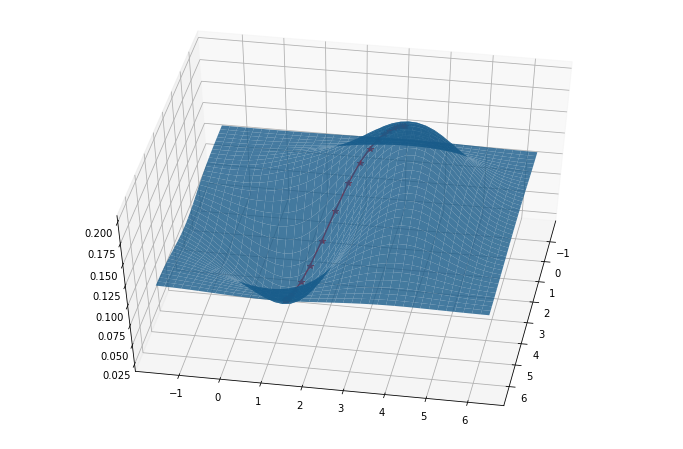

Initial parameter values:
mu1:[3.5,1.5] 
Optimized parameter values:
mu1:[0.88, 3.1] 
Time for 1500 steps is 1.5249269008636475 seconds.
The average time for each step is 0.0010166179339090983 seconds.


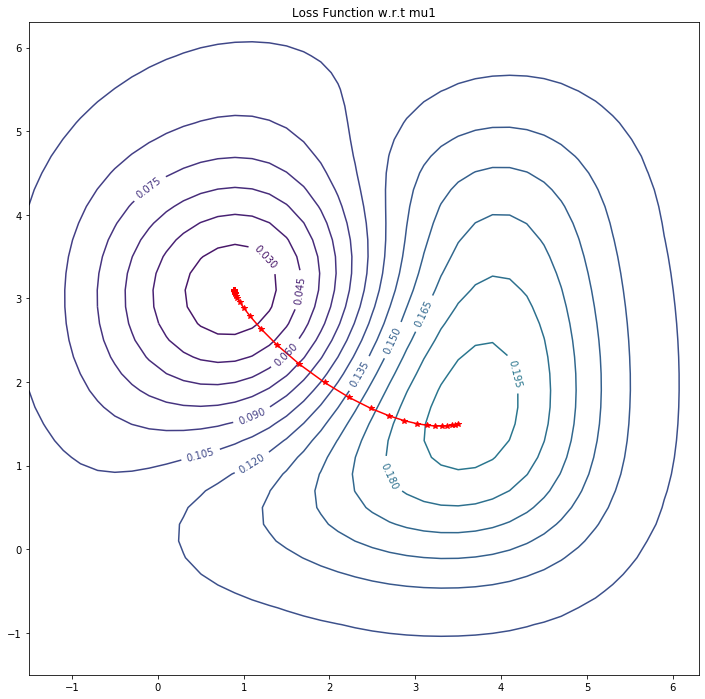

In [16]:
prange = np.array([[-1.5, 6.5], [-1.5, 6.5]]);
descent_mu1(X, 0.2, mu2, 4, np.array([3.5, 1.5]), 1500, prange)

(151, 2)
(151,)


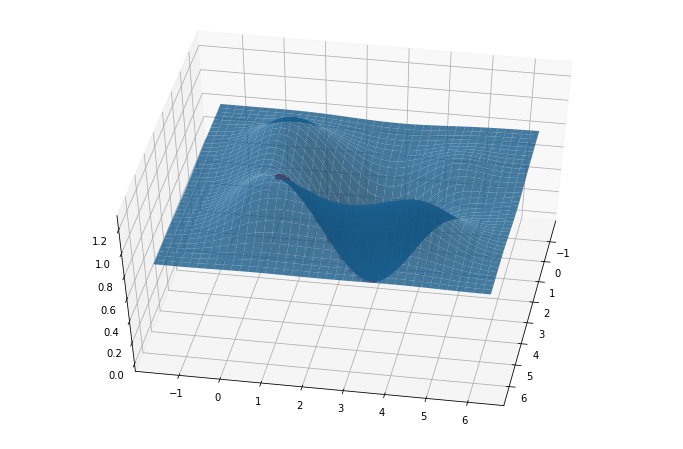

Initial parameter values:
mu2:[1,4] 
Optimized parameter values:
mu2:[2.91, 2.04] 
Time for 150 steps is 0.15359711647033691 seconds.
The average time for each step is 0.0010239807764689127 seconds.


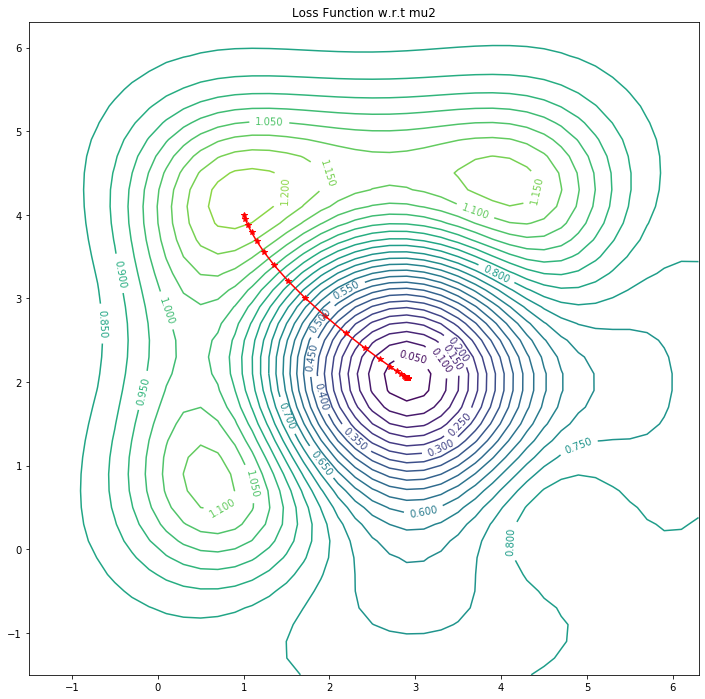

In [17]:
descent_mu2(X, 0.2, mu1, 0.5, np.array([1, 4]), 150)

If we choose initialization parameters carefully around the truth value. The gradient descent performed quite well.

Initial parameter values:
Weight: 0.2  mu1:[1.5, 3.0]  mu2:[3.0, 2.4]
Optimized parameter values:
Weight: 0.31  mu1:[1.07, 2.98]  mu2:[3.02, 1.99]
Time for 400 steps is 0.46652913093566895 seconds.
The average time for each step is 0.0011663228273391725 seconds.


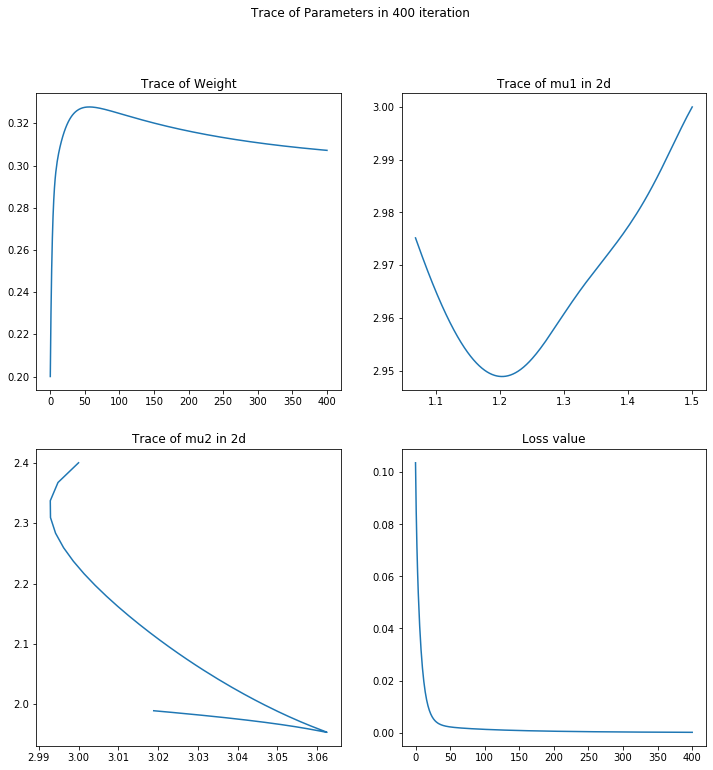

In [45]:
test(0.1, np.array([0.2, 1.5, 3, 3, 2.4]), 400)

Initial parameter values:
Weight: 0.2  mu1:[1.0, 4.0]  mu2:[4.0, 1.0]
Optimized parameter values:
Weight: 0.3  mu1:[1.0, 3.02]  mu2:[3.0, 2.0]


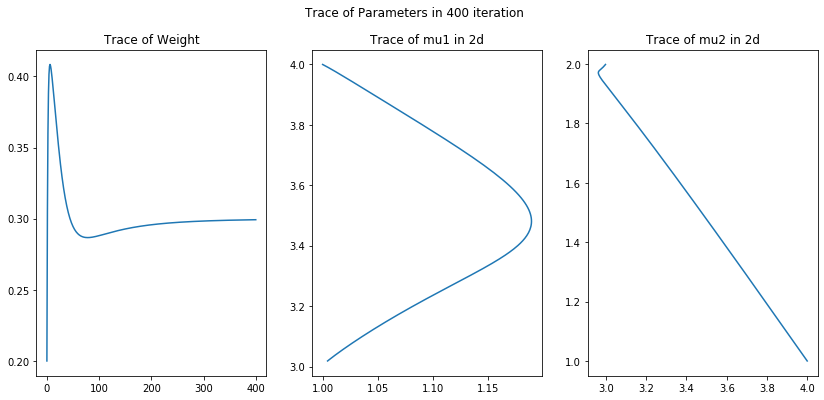

In [15]:
test(0.1, np.array([0.2, 1, 4, 4, 1]), 400)

Initial parameter values:
Weight: 0.7  mu1:[1.0, 4.0]  mu2:[4.0, 1.0]
Optimized parameter values:
Weight: 0.3  mu1:[1.02, 3.01]  mu2:[3.0, 2.0]


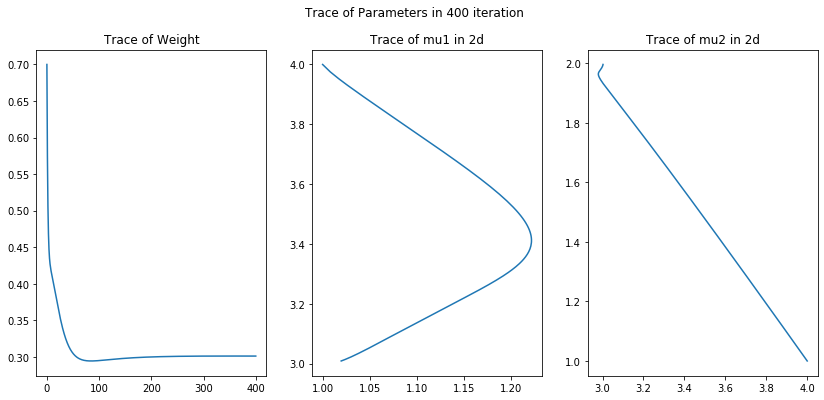

In [95]:
test(0.1, np.array([0.7, 1, 4, 4, 1]), 400)

Initial parameter values:
Weight: 0.2  mu1:[1.0, 1.0]  mu2:[4.0, 4.0]
Optimized parameter values:
Weight: 0.31  mu1:[1.1, 2.96]  mu2:[3.03, 1.98]


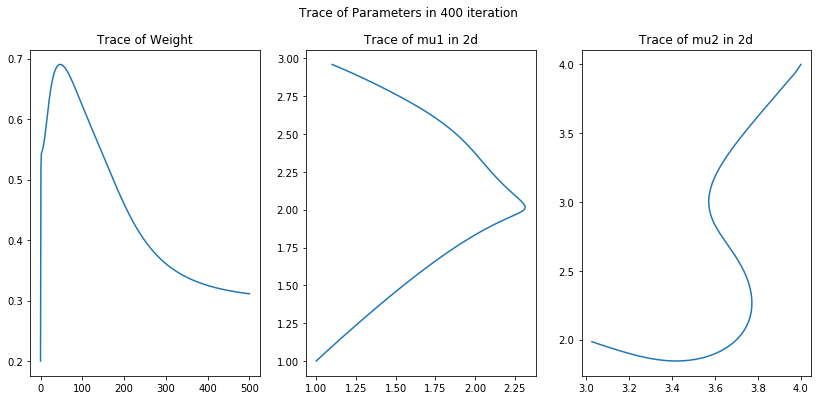

In [96]:
test(0.2, np.array([0.2, 1, 1, 4, 4]), 500)

Initial parameter values:
Weight: 0.7  mu1:[1.0, 1.0]  mu2:[4.0, 4.0]
Optimized parameter values:
Weight: 0.31  mu1:[1.07, 2.97]  mu2:[3.02, 1.99]


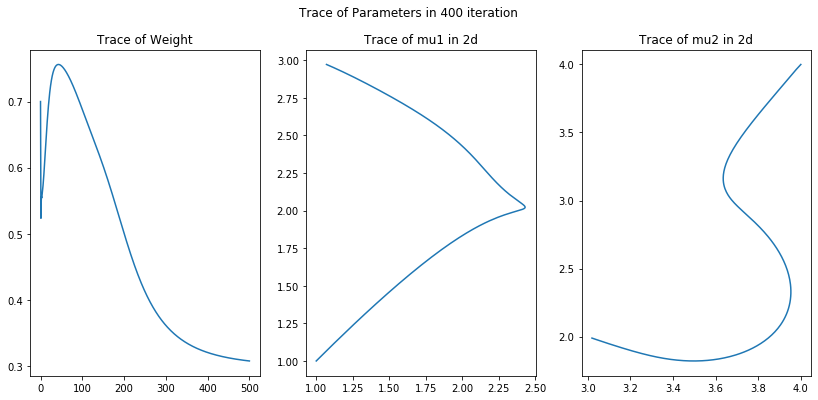

In [97]:
test(0.25, np.array([0.7, 1, 1, 4, 4]), 500)

But if we choose initialization paramteters far away from the truth value. Gradient descent may lead to local minimum, which is not the truth value.

Initial parameter values:
Weight: 0.8  mu1:[4.0, 4.0]  mu2:[4.0, 3.0]
Optimized parameter values:
Weight: 0.2  mu1:[5.66, 5.55]  mu2:[2.69, 2.15]
Time for 500 steps is 0.6010618209838867 seconds.
The average time for each step is 0.0012021236419677735 seconds.


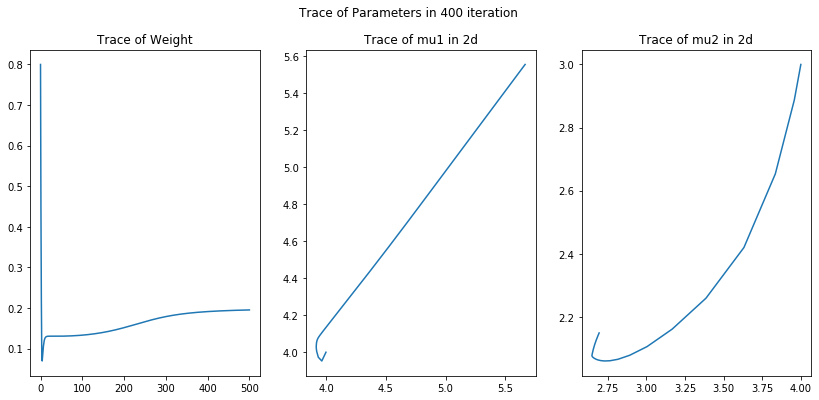

In [31]:
test(0.4, np.array([0.8, 4, 4, 4, 3]), 500)

Initial parameter values:
Weight: 0.6  mu1:[3.0, 2.0]  mu2:[4.0, 4.0]
Optimized parameter values:
Weight: 0.83  mu1:[2.67, 2.14]  mu2:[5.33, 4.54]
Time for 500 steps is 0.5694539546966553 seconds.
The average time for each step is 0.0011389079093933106 seconds.


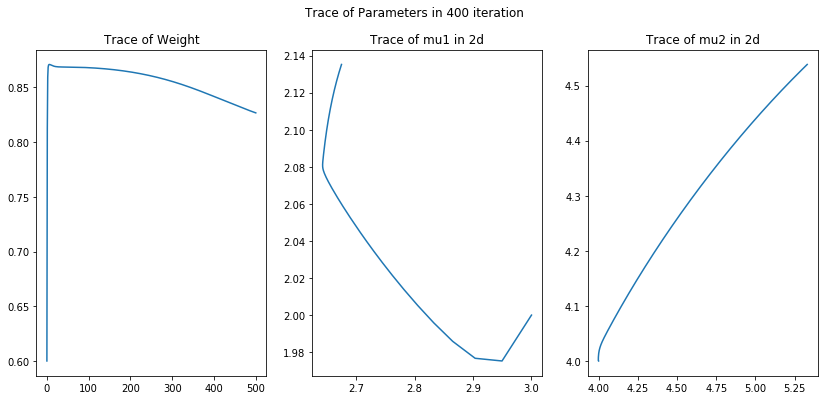

In [28]:
test(0.2, np.array([0.6, 3, 2, 4, 4]), 500)

Gradient Flow in Wasserstein Space


We discretize the area $[0, 5]^2$ into N by N little squares. We only consider the values of the $(N-1)^2$ interior points values. The exterior points are all zero by the zero neumann condition.


The natural gradient descent algo is as follows:
$$\theta^{(n+1)} = \theta^{(n)} -\eta_n G_w(\theta)^{-1} \nabla_{\theta}U(\theta)$$
Where $G_w$ is the Wasserstein matrix, which is defined to be:
$$G_{ij} = \int_{\Omega}\frac{m_i(x, \theta)m_j(x, \theta)}{\rho(x, \theta)}dx$$
After discretization, 
$$G_{i, j} = \sum_{i, j}[(m_i)_0^T\rho(x_{i, j}, \theta)(m_j)_0 + (m_i)_1^T\rho(x_{i, j}, \theta)(m_j)_1] = (m_i)_0^T\Sigma(m_j)_0 + (m_i)_1^T\Sigma(m_j)_1$$
Where,
$$  \Sigma = 
 \begin{bmatrix}
   \frac{1}{\rho(x_{1, 1})} &  &  & \\ 
   & \frac{1}{\rho(x_{1, 2})} &  & \\ 
   &  &  \ddots & \\ 
   &  &   & \frac{1}{\rho(x_{N-1, N-1})} 
 \end{bmatrix}
$$

In [18]:
##compute the matrix sigma
def sigma(X, N, w, mu1, mu2):
    diagonal = 1/model(X, w, mu1, mu2);
    data = np.array([diagonal]);
    diags = np.array([0]);
    sig = spdiags(data, diags, (N-1)**2, (N-1)**2).toarray();
    return sig;

##compute the matrix big sigma
##that is a concatenation of sigma
def Sigma(X, N, w, mu1, mu2):
    sig = sigma(X, N, w, mu1, mu2);
    I = np.identity(2);
    Sig = kron(I, sig).toarray();
    return Sig;

##compute the matrix C
def Cmatrix(X, N, w, mu1, mu2):
    C = Sigma(X, N, w, mu1, mu2);
    C = 2*C;
    C = np.linalg.inv(C);
    return C;

Compute the matrix $A = [A_1^T, A_2^T]^T$ that represents the process of taking divergence

In [19]:
#compute the matrix A that represents the process of taking divergence
#returns a 2*(N-1)**2 by (N-1)**2 matrix
def discretize(N, dx, dy):
    ones = np.ones(N-1);
    diags = np.array([-1, 1]);
    data = [-ones, ones];
    B = spdiags(data, diags, N-1, N-1).toarray();
    I = np.identity(N-1);
    A1 = kron(I, B).toarray()/(2*dx);
    A2 = kron(B, I).toarray()/(2*dy);
    return np.concatenate((A1, A2), axis=0);

for a given discretized $m_i$, which is of dimension $(N-1)^2 \times 2$. let's denote its as $m_i = [M_1, M_2]$
We want to solve the following quadratic optimization problem:
$$\begin{cases} min\{M_1^T\Sigma M_1 + M_2^T\Sigma M_2\} \\ A_1M_1 + A_2M_2 = -\rho_{\theta_i} \end{cases}$$
Let $M = [M_1^T, M_2^T]^T \in R^{2(N-1)^2}$ and let $C^{-1} = 2\begin{bmatrix} \Sigma & 0 \\ 0 & \Sigma \end{bmatrix}$ we have:
$$\begin{cases}
min\{ \frac{1}{2}M^TC^{-1}M \} \\
A^TM = -\rho_{\theta_i}
\end{cases}$$
We use Lagrange method to solve this system. Introduce lagrange multiplier $\lambda$. define:
$$L(M, \lambda) = \frac{1}{2}M^TC^{-1}M + \lambda^T(A^TM + \rho_{\theta_i})$$
$$= \frac{1}{2}M^TC^{-1}M + (A\lambda)^TM + \lambda^T\rho_{\theta_i}$$
The max of this quadratic function is achieved when:
$$C^{-1}M + A\lambda = 0$$
Plug this into the linear condition we get:
$$\lambda = (A^TCA)^{-1}\rho_{\theta_i}$$
Therefore, 
$$M = -CA(A^TCA)^{-1}\rho_{\theta_i}$$
Specifically,
$$M_w = -CA(A^TCA)^{-1}\frac{d\rho}{dw}$$
$$M_{\mu_1} = -CA(A^TCA)^{-1}\frac{d\rho}{d\mu_1}$$
$$M_{\mu_2} = -CA(A^TCA)^{-1}\frac{d\rho}{d\mu_2}$$
We have:
$$P = 
[M_1, M_{\mu_1}, M_{\mu_2}] = -CA(A^TCA)^{-1} [\frac{d\rho}{dw}, \frac{d\rho}{d\mu_1}, \frac{d\rho}{d\mu_2}]$$

In [20]:
##Matrix A is the matrix that represents the process of taking divergence
##C is a matrix
##this function returns a discretized function m, a vector of R^2(N-1)^2 = [m1, m2]^T
def getdis_m_w(N, X, mu1, mu2, A, C):
    M = np.matmul(C, A);
    S = np.matmul(np.transpose(A), M);
    eta = dpdw(X, mu1, mu2)
    lamda = np.matmul(np.linalg.inv(S), eta)
    m = -np.matmul(M, lamda)
    return m;

#this function returns a pair of discretize m: [m_2, m_3]
def getdis_m_mu1(N, X, w, mu1, mu2, A, C, dpmu1):
    M = np.matmul(C, A);
    S = np.matmul(np.transpose(A), M);
    eta = dpmu1;
    lamda = np.matmul(np.linalg.inv(S), eta)
    m = -np.matmul(M, lamda);
    return np.array(m);

#this function returns a pair of discretize m: [m_4, m_5]
def getdis_m_mu2(N, X, w, mu1, mu2, A, C):
    M = np.matmul(C, A);
    S = np.matmul(np.transpose(A), M);
    eta = dpdmu2(w, X, mu2);
    lamda = np.matmul(np.linalg.inv(S), eta)
    m = -np.matmul(M, lamda);
    return np.array(m);

Let's compute and store each $m_i: m_1, m_2, m_3, m_4, m_5$
Note that each $m_i$ should be a $(N+1)^2 \times 2$ matrix
And then compute the matrix G:
$$G_{i, j} = \sum_{i, j}[(m_i)_0^T\rho(x_{i, j}, \theta)(m_j)_0 + (m_i)_1^T\rho(x_{i, j}, \theta)(m_j)_1] = (m_i)_0^T\Sigma(m_j)_0 + (m_i)_1^T\Sigma(m_j)_1$$
Therefore:
$$G = P^T \begin{bmatrix} \Sigma & 0 \\ 0 & \Sigma \end{bmatrix} P$$

In [26]:
#P is the gradient of p
def Gmatrix(w, mu1, mu2, X, N, dx, dy, A, P):
    Sig = Sigma(X, N, w, mu1, mu2);
    C = 2*Sig; C = np.linalg.inv(C);
    CA = np.matmul(C, A);
    ACAinv = np.linalg.inv(np.matmul(np.transpose(A), CA));
    K = np.matmul(CA, ACAinv)
    mid = time.time();
    M = -np.matmul(K, np.transpose(P)); M = np.transpose(M);
    G = np.inner(M, np.matmul(M, Sig));
    return G;

In [22]:
A = discretize(31, dx, dy); 
w = 0.62649174; mu1 = np.array([0.5, 3.5]); mu2 = np.array([5.3, 9.1]);
[P, grad] = gradient_all(X, w, mu1, mu2);
Gmatrix(w, mu1, mu2, X, 31, dx, dy, A, P)

Entire time: 0.4873318672180176 second.
Time to compute -CA(ATCA)inv is 0.48088598251342773 second.


array([[ 3.15385526e+03,  1.01176201e+03, -2.61717838e+02,
        -1.12025632e-02, -4.08478399e-02],
       [ 1.01176201e+03,  3.28462279e+02, -8.41826827e+01,
        -3.71591623e-03, -1.36555538e-02],
       [-2.61717838e+02, -8.41826827e+01,  2.87869176e+01,
         8.58215127e-04,  3.11370520e-03],
       [-1.12025632e-02, -3.71591623e-03,  8.58215127e-04,
         5.69671931e-07,  3.41283878e-06],
       [-4.08478399e-02, -1.36555538e-02,  3.11370520e-03,
         3.41283878e-06,  2.20566494e-05]])

In [23]:
def nature_gradient_test(lr, initial, iteration):
    para = initial;
    trace = [para]; tracevalue = [loss(X, para[0], np.array([para[1], para[2]]), np.array([para[3], para[4]]))];
    A = discretize(31, dx, dy);
    start = time.time();
    for i in range(iteration):
        [P, grad] = gradient_all(X, para[0], np.array([para[1], para[2]]), np.array([para[3], para[4]]));
        G = Gmatrix(para[0], np.array([para[1], para[2]]), np.array([para[3], para[4]]), X, 31, dx, dy, A, P);
        para = para - lr*np.matmul(np.linalg.inv(G), grad);
        trace.append(para);
    end = time.time();
    for i in range(iteration):
        tracevalue.append(loss(X, trace[i+1][0], np.array([trace[i+1][1], trace[i+1][2]]), np.array([trace[i+1][3], trace[i+1][4]])));
    trace= np.array(trace); tracevalue = np.array(tracevalue);
    weight_trace = trace[:, 0];
    mu1_trace = trace[:, 1:3];
    mu2_trace = trace[:, 3:5];
    #plot the trace of parameters
    fig, ax = plt.subplots(2, 2, figsize=(12, 12));
    ax[0][0].plot(weight_trace);
    ax[0][1].plot(mu1_trace[:, 0], mu1_trace[:, 1]);
    ax[1][0].plot(mu2_trace[:, 0], mu2_trace[:, 1]);
    ax[1][1].plot(tracevalue);
    fig.suptitle("Trace of Parameters in 400 iteration");
    ax[0][0].set_title("Trace of Weight");
    ax[0][1].set_title("Trace of mu1 in 2d");
    ax[1][0].set_title("Trace of mu2 in 2d");
    ax[1][1].set_title("Loss value");
    print("Initial parameter values:");
    print("Weight: {}  mu1:[{}, {}]  mu2:[{}, {}]".format(initial[0], initial[1], initial[2], 
                                                     initial[3], initial[4]))
    print("Optimized parameter values:");
    print("Weight: {}  mu1:[{}, {}]  mu2:[{}, {}]".format(round(para[0], 2), round(para[1], 2), round(para[2], 2), 
                                                     round(para[3], 2), round(para[4], 2)));
    print("Time for {} steps is {} seconds".format(iteration, end-start));
    print("Average time for each step is {} seconds".format((end-start)/iteration));
    lo = loss(X, para[0], np.array([para[1], para[2]]), np.array([para[3], para[4]]));
    print("The loss is {}.".format(lo));


Initial parameter values:
Weight: 0.8  mu1:[4.0, 4.0]  mu2:[4.0, 3.0]
Optimized parameter values:
Weight: 0.14  mu1:[4.46, 4.57]  mu2:[2.67, 2.11]
Time for 300 steps is 0.36841392517089844 seconds.
The average time for each step is 0.0012280464172363282 seconds.
The loss is 1.1232253795520861.


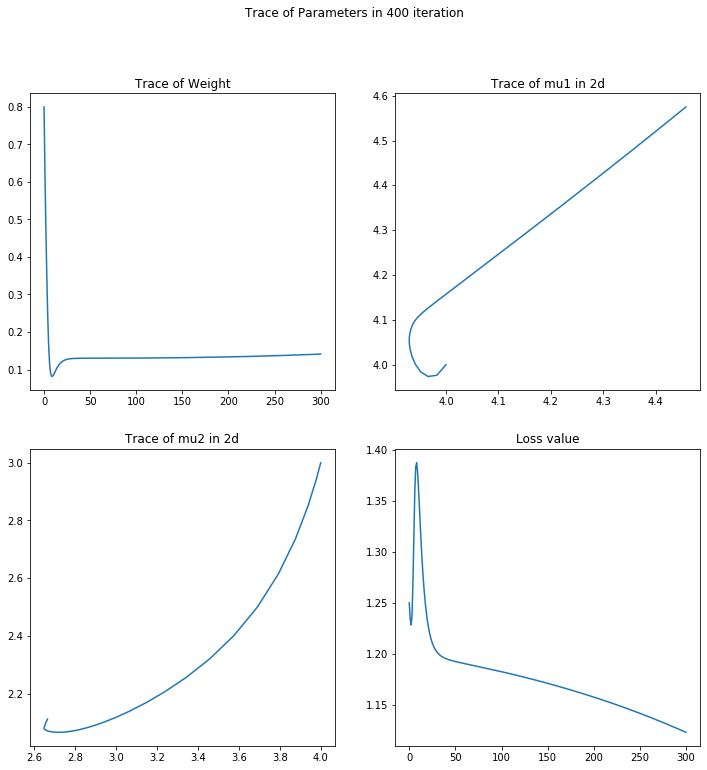

In [24]:
test(0.2, np.array([0.8, 4, 4, 4, 3]), 300)

Initial parameter values:
Weight: 0.8  mu1:[4.0, 4.0]  mu2:[4.0, 3.0]
Optimized parameter values:
Weight: 0.3  mu1:[0.92, 3.02]  mu2:[2.99, 2.0]
Time for 800 steps is 436.17929887771606 seconds
Average time for each step is 0.5452241235971451 seconds
The loss is 0.00020327524082592796.


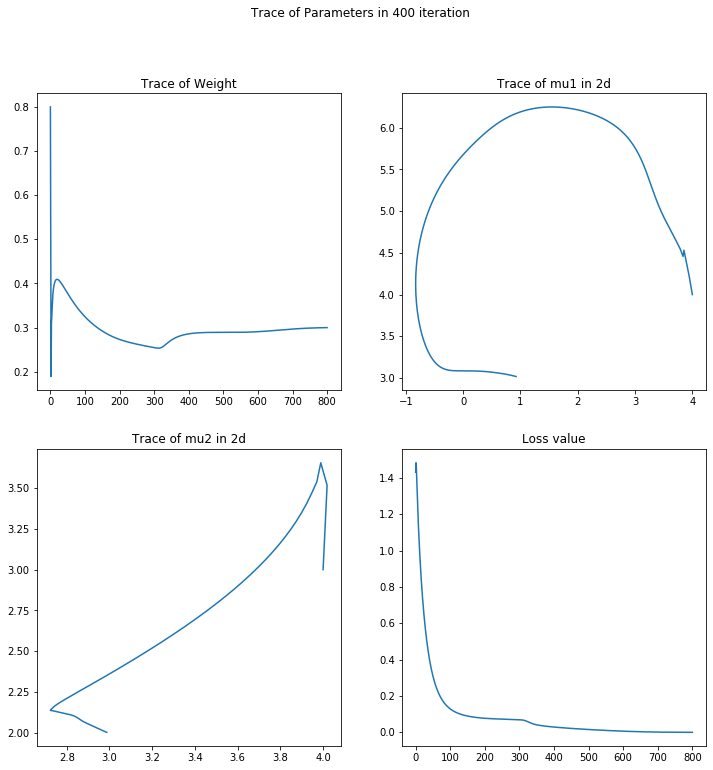

In [40]:
nature_gradient_test(0.5, np.array([0.8, 4, 4, 4, 3]), 800);

In [42]:
loss(X, 0.8, np.array([4, 4]), np.array([4, 3]))
truth(X)

array([0.00096308, 0.00141769, 0.00204525, 0.00289078, 0.00400157,
       0.00542283, 0.00719163, 0.00932954, 0.01183458, 0.01467378,
       0.01777757, 0.02103779, 0.02431046, 0.02742405, 0.03019309,
       0.03243582, 0.03399368, 0.0347498 , 0.03464347, 0.03367814,
       0.03192142, 0.02949719, 0.02657087, 0.02333056, 0.01996693,
       0.01665483, 0.01353915, 0.01072623, 0.00828118, 0.00623038,
       0.00124559, 0.00181089, 0.0025814 , 0.00360728, 0.00494024,
       0.00662858, 0.00871044, 0.01120573, 0.01410735, 0.01737329,
       0.02092083, 0.02462475, 0.02832085, 0.03181544, 0.03490078,
       0.03737469, 0.03906228, 0.03983629, 0.03963294, 0.03846046,
       0.03639885, 0.03359064, 0.03022432, 0.026513  , 0.0226719 ,
       0.01889781, 0.0153533 , 0.01215723, 0.00938188, 0.00705585,
       0.00161051, 0.00231129, 0.00325291, 0.00448943, 0.00607518,
       0.00805912, 0.01047754, 0.01334553, 0.01664793, 0.02033124,
       0.02429815, 0.02840625, 0.03247243, 0.03628372, 0.03961

Initial parameter values:
Weight: 0.4  mu1:[5.0, 1.0]  mu2:[4.0, 3.0]
Optimized parameter values:
Weight: 0.7  mu1:[3.0, 2.0]  mu2:[1.0, 3.0]
Time for 2000 steps is 2.660667896270752 seconds.
The average time for each step is 0.001330333948135376 seconds.
The loss is 8.612419177368256e-10.


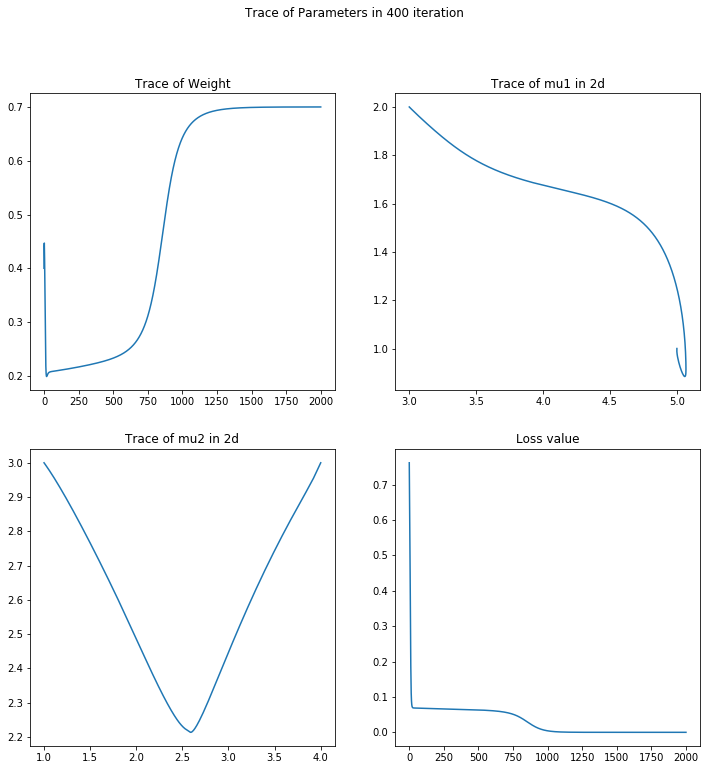

In [55]:
test(0.2, np.array([0.4, 5, 1, 4, 3]), 2000)

Initial parameter values:
Weight: 0.4  mu1:[5.0, 1.0]  mu2:[4.0, 3.0]
Optimized parameter values:
Weight: 0.25  mu1:[5.99, 1.63]  mu2:[2.64, 2.16]
Time for 800 steps is 354.924831867218 seconds
Average time for each step is 0.4436560398340225 seconds
The loss is 0.07037425223399872.


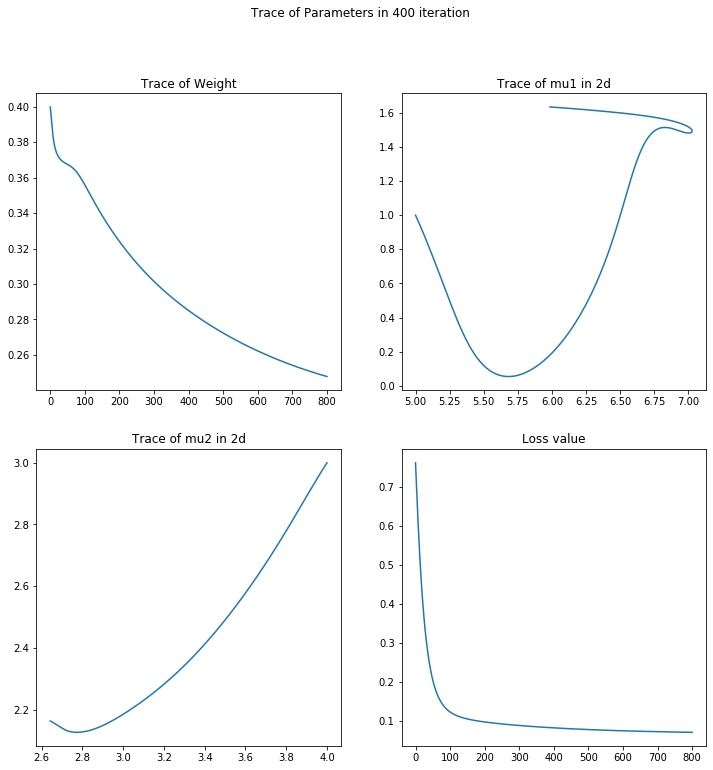

In [47]:
nature_gradient_test(0.5, np.array([0.4, 5, 1, 4, 3]), 800);

In [37]:
#with fixed w and mu2, compute the Wasserstein matrix (of size 2 by 2) 
#with respect to mu1 only
def Gmatrix_mu1(w, mu1, mu2, X, N, dx, dy, A, dpmu1):
    Sig = Sigma(X, N, w, mu1, mu2);
    C = 2*Sig; C = np.linalg.inv(C);
    mmu1 = getdis_m_mu1(N, X, w, mu1, mu2, A, C, dpmu1);
    return np.matmul(np.transpose(mmu1), np.matmul(Sig, mmu1));

#with fixed w and mu1, compute the Wasserstein matrix (of size 2 by 2) 
#with respect to mu2 only
def Gmatrix_mu2(w, mu1, mu2, X, N, dx, dy, A):
    Sig = Sigma(X, N, w, mu1, mu2);
    C = 2*Sig; C = np.linalg.inv(C);
    mmu2 = getdis_m_mu2(N, X, w, mu1, mu2, A, C);
    return np.matmul(np.transpose(mmu2), np.matmul(Sig, mmu2));

In [38]:
## fix w, mu2, do the natural gradient descent algo on parameter mu1 only
#plot the convergence history on the loss function
def nature_descent_mu1(X, w, mu2, lr, initial, iteration, plotrange):
    para = initial; trace = [para]; tracevalue = [loss(X, w, para, mu2)];
    A = discretize(31, dx, dy);
    start = time.time();
    for i in range(iteration):
        [dpmu1, grad] = gradient_mu1_all(X, w, para, mu2);
        G = Gmatrix_mu1(w, para, mu2, X, 31, dx, dy, A, dpmu1)
        step = lr*np.matmul(np.linalg.inv(G),grad);
        para = para - step;
        trace.append(para);
        tracevalue.append(loss(X, w, para, mu2));
    end = time.time();
    trace = np.array(trace); tracevalue = np.array(tracevalue);
    plot_loss_mu1(X, w, mu2, grid, plotrange[0], plotrange[1],trace, tracevalue);
    print("Initial parameter values:");
    print("mu1:[{},{}] ".format(initial[0], initial[1]))
    print("Optimized parameter values:");
    print("mu1:[{}, {}] ".format(round(para[0], 2), round(para[1], 2)));
    print("Time for {} steps is {} seconds.".format(iteration, end-start));
    print("The average time for each step is {} seconds.".format((end-start)/iteration));
    
    
## fix w, mu1, do the natural gradient descent algo on parameter mu2 only
#plot the convergence history on the loss function
def nature_descent_mu2(X, w, mu1, lr, initial, iteration, plotrange):
    para = initial; trace = [para]; tracevalue = [loss(X, w, mu1, para)];
    A = discretize(31, dx, dy);
    start = time.time();
    for i in range(iteration):
        G = Gmatrix_mu2(w, mu1, para, X, 31, dx, dy, A)
        step = lr*np.matmul(np.linalg.inv(G),dudmu2(X, w, mu1, para));
        para = para - step;
        trace.append(para);
        tracevalue.append(loss(X, w, mu1, para));
    end = time.time();
    trace = np.array(trace); tracevalue = np.array(tracevalue);
    plot_loss_mu2(X, w, mu1, grid, plotrange[0], plotrange[1],trace, tracevalue);
    print("Initial parameter values:");
    print("mu1:[{},{}] ".format(initial[0], initial[1]))
    print("Optimized parameter values:");
    print("mu1:[{}, {}] ".format(round(para[0], 2), round(para[1], 2)));
    print("Time for {} steps is {} seconds.".format(iteration, end-start));
    print("The average time for each step is {} seconds.".format((end-start)/iteration));
    

(40, 40)
(40, 40)
(40, 40)
(151, 2)
(151,)


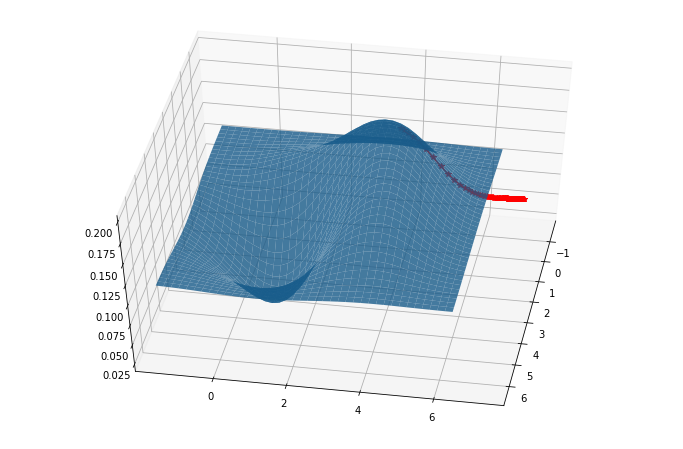

Initial parameter values:
mu1:[4.0,1.5] 
Optimized parameter values:
mu1:[7.25, 0.82] 
Time for 150 steps is 0.16375994682312012 seconds.
The average time for each step is 0.0010917329788208009 seconds.


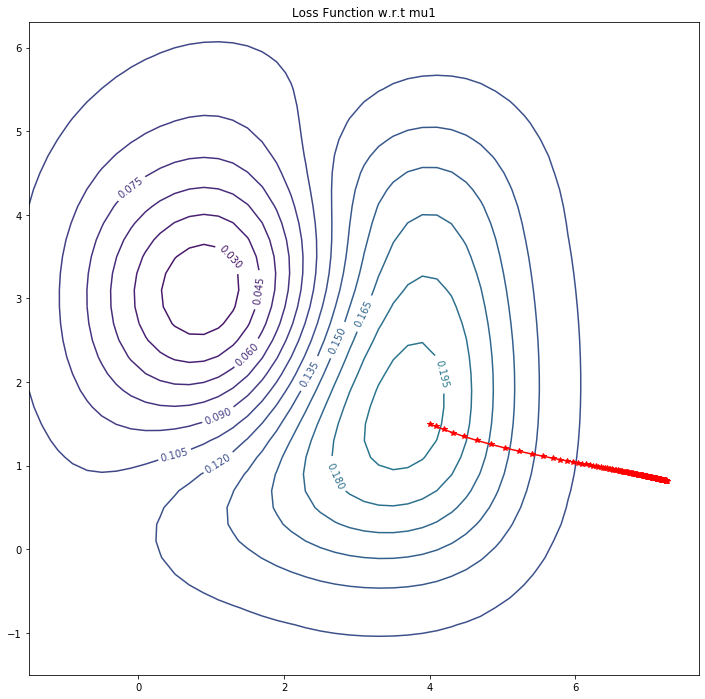

In [39]:
#ordinary gradient descent
descent_mu1(X, 0.2, mu2, 4, np.array([4, 1.5]), 150, prange)

(55, 55)
(55, 55)
(55, 55)
(151, 2)
(151,)


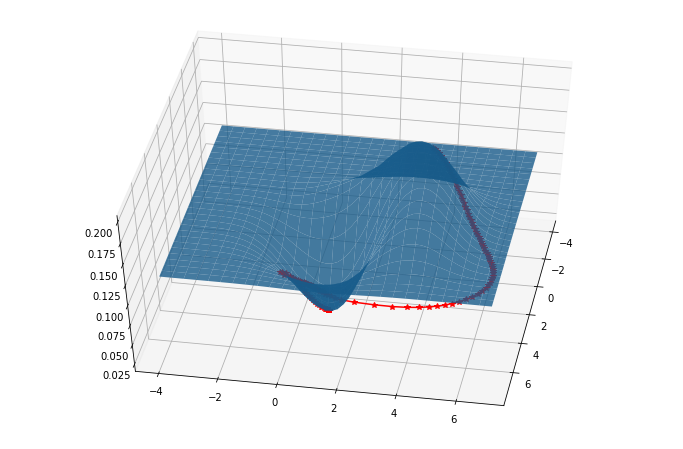

Initial parameter values:
mu1:[4.0,1.5] 
Optimized parameter values:
mu1:[0.88, 3.1] 
Time for 150 steps is 55.43841505050659 seconds.
The average time for each step is 0.36958943367004393 seconds.


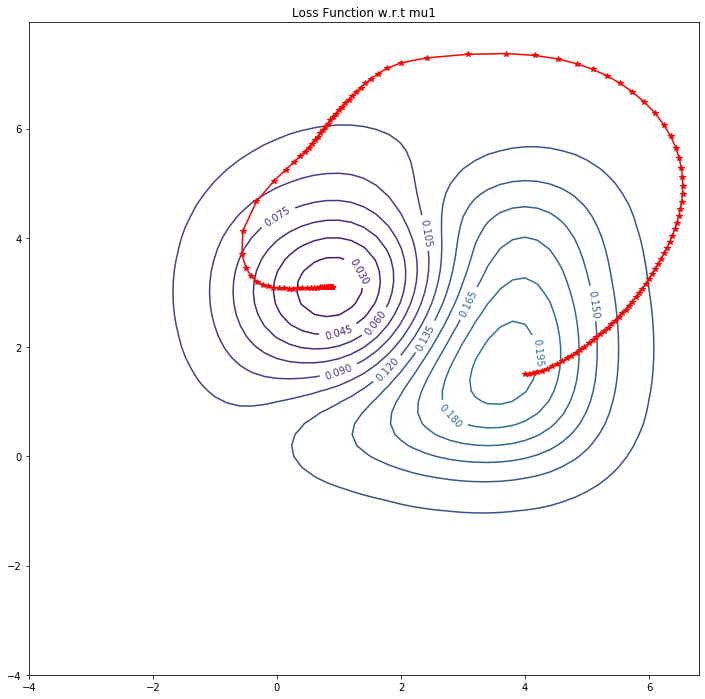

In [46]:
newrange = np.array([[-4, 7], [-4, 7]])
nature_descent_mu1(X, 0.2, mu2, 5, np.array([4, 1.5]), 150, newrange)

(18, 2)
(18,)


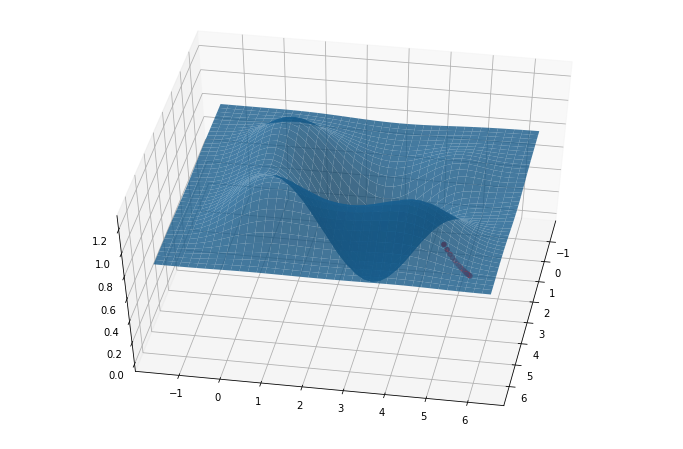

Initial parameter values:
mu2:[5,5] 
Optimized parameter values:
mu2:[5.72, 5.63] 


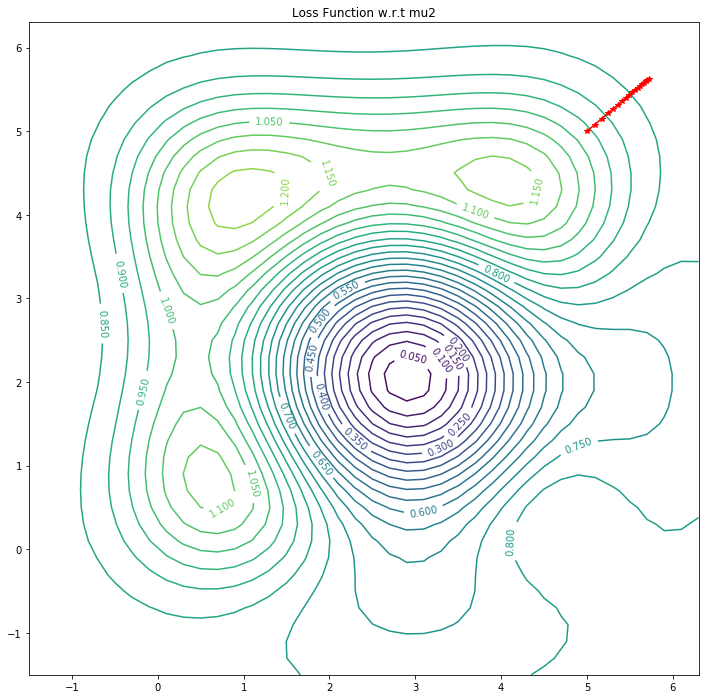

In [64]:
#ordinary gradient descent on mu2 only
descent_mu2(X, 0.2, mu1, 0.5, np.array([5, 5]), 60)

(151, 2)
(151,)


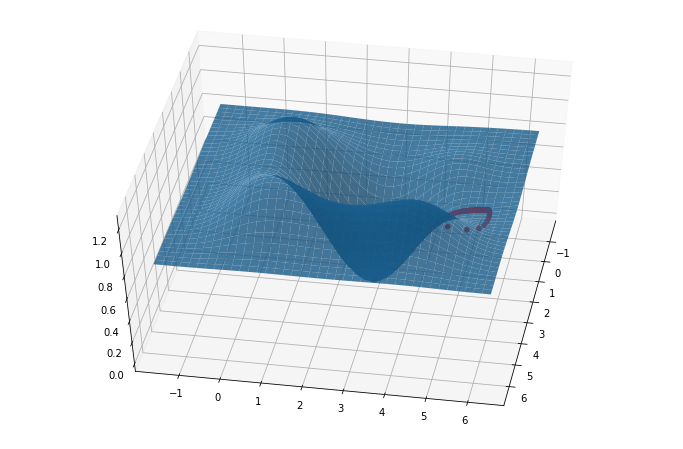

Initial parameter values:
mu1:[5.0,4.5] 
Optimized parameter values:
mu1:[2.91, 2.04] 
Time for 150 steps is 55.63252019882202 seconds.
The average time for each step is 0.37088346799214683 seconds.


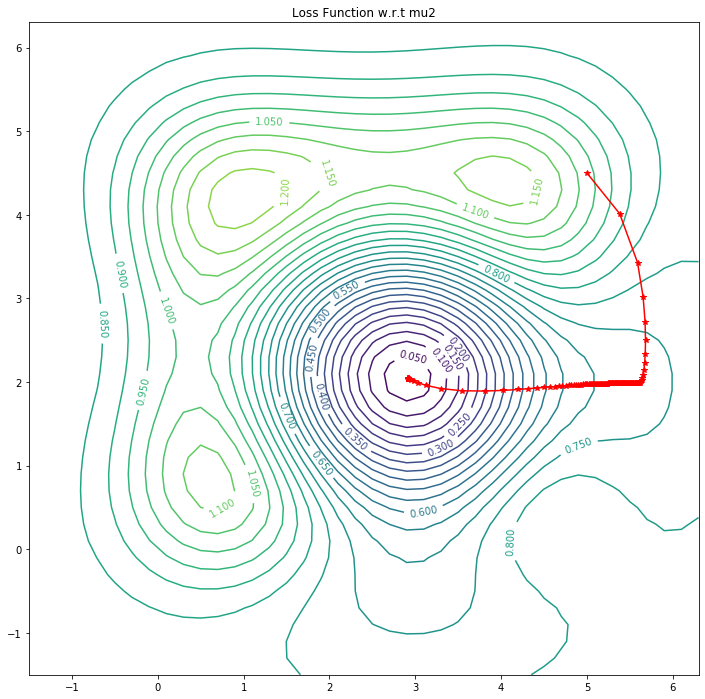

In [45]:
nature_descent_mu2(X, 0.2, mu1, 10, np.array([5, 4.5]), 150, prange)

In [77]:
def descent_mu1_search(X, w, mu2, lr, iteration, xrange, yrange):
    traces = [];
    A = discretize(31, dx, dy);
    for i in range(-1, 7):
        for j in range(-1, 7):
            initial = np.array([i, j]); para = initial; trace = [para];
            for k in range(iteration):
                G = Gmatrix_mu1(w, para, mu2, X, 31, dx, dy, A)
                step = lr*np.matmul(np.linalg.inv(G),dudmu1(X, w, para, mu2));
                para = para - step;
                trace.append(para);
            trace = np.array(trace);
            traces.append(trace);
    traces= np.array(traces);
    x = np.arange(xrange[0],xrange[1],grid);
    y = np.arange(yrange[0],yrange[1],grid);
    P,Q = np.meshgrid(x,y)
    Z = np.zeros((x.size, y.size));
    for i in range(x.size):
        for j in range(y.size):
            Z[i, j] = loss(X, w, mu1, np.array([grid*i+xrange[0], grid*j+yrange[0]]));
    fig, ax = plt.subplots(figsize=(12, 12));
    level = np.arange(0, 1.5, 0.05);
    CS = ax.contour(Q,P,Z,levels = level);
    ax.clabel(CS, inline=True, fontsize=10);
    ax.set_title('Loss Function w.r.t mu1')
    for t in traces:
        ax.plot(t[:, 0], t[:, 1], '*-', c='red');
        

def descent_mu2_search(X, w, mu1, lr, iteration, xrange, yrange):
    traces = [];
    A = discretize(31, dx, dy);
    for i in range(6):
        for j in range(6):
            initial = np.array([i, j]); para = initial; trace = [para];
            for k in range(iteration):
                G = Gmatrix_mu2(w, mu1, para, X, 31, dx, dy, A)
                step = lr*np.matmul(np.linalg.inv(G),dudmu2(X, w, mu1, para));
                para = para - step;
                trace.append(para);
            trace = np.array(trace);
            traces.append(trace);
    traces= np.array(traces);
    x = np.arange(xrange[0],xrange[1],grid);
    y = np.arange(yrange[0],yrange[1],grid);
    P,Q = np.meshgrid(x,y)
    Z = np.zeros((x.size, y.size));
    for i in range(x.size):
        for j in range(y.size):
            Z[i, j] = loss(X, w, mu1, np.array([grid*i+xrange[0], grid*j+yrange[0]]));
    fig, ax = plt.subplots(figsize=(12, 12));
    level = np.arange(0, 1.5, 0.05);
    CS = ax.contour(Q,P,Z,levels = level);
    ax.clabel(CS, inline=True, fontsize=10);
    ax.set_title('Loss Function w.r.t mu2')
    for t in traces:
        ax.plot(t[:, 0], t[:, 1], '*-', c='red');
        
def ordinary_descent_mu2_search(X, w, mu1, lr, iteration, xrange, yrange):
    traces = [];
    for i in range(6):
        for j in range(6):
            initial = np.array([i, j]); para = initial; trace = [para];
            for k in range(iteration):
                step = lr*dudmu2(X, w, mu1, para);
                para = para - step;
                trace.append(para);
            trace = np.array(trace);
            traces.append(trace);
    traces= np.array(traces);
    x = np.arange(xrange[0],xrange[1],grid);
    y = np.arange(yrange[0],yrange[1],grid);
    P,Q = np.meshgrid(x,y)
    Z = np.zeros((x.size, y.size));
    for i in range(x.size):
        for j in range(y.size):
            Z[i, j] = loss(X, w, mu1, np.array([grid*i+xrange[0], grid*j+yrange[0]]));
    fig, ax = plt.subplots(figsize=(12, 12));
    level = np.arange(0, 1.5, 0.05);
    CS = ax.contour(Q,P,Z,levels = level);
    ax.clabel(CS, inline=True, fontsize=10);
    ax.set_title('Loss Function w.r.t mu2')
    for t in traces:
        ax.plot(t[:, 0], t[:, 1], '*-', c='red');


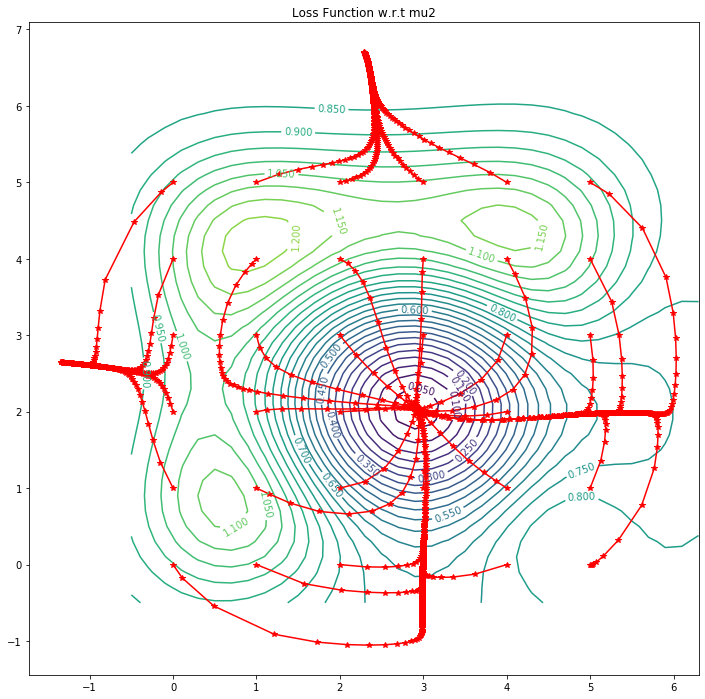

In [73]:
descent_mu2_search(X, 0.2, mu1, 10, 150, np.array([-0.5, 6.5]), np.array([-0.5, 6.5]))

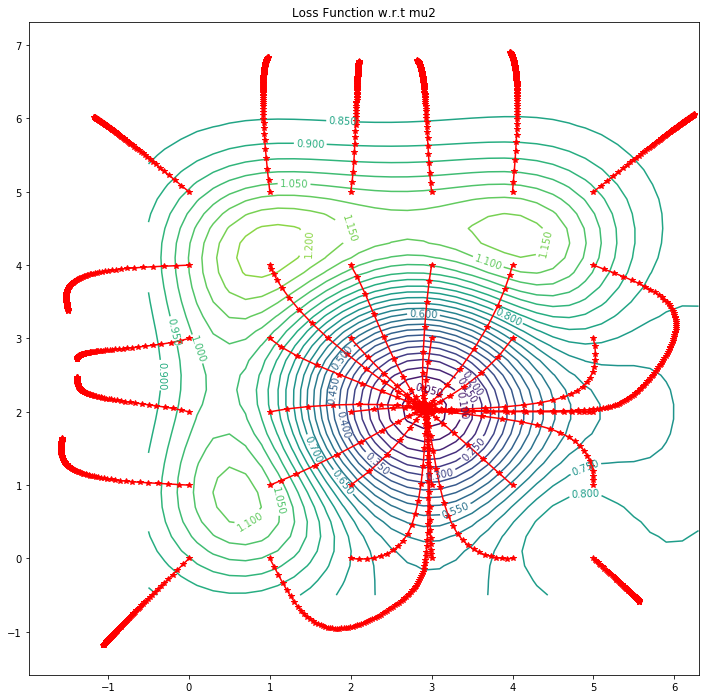

In [76]:
ordinary_descent_mu2_search(X, 0.2, mu1, 0.5, 150, np.array([-0.5, 6.5]), np.array([-0.5, 6.5]))

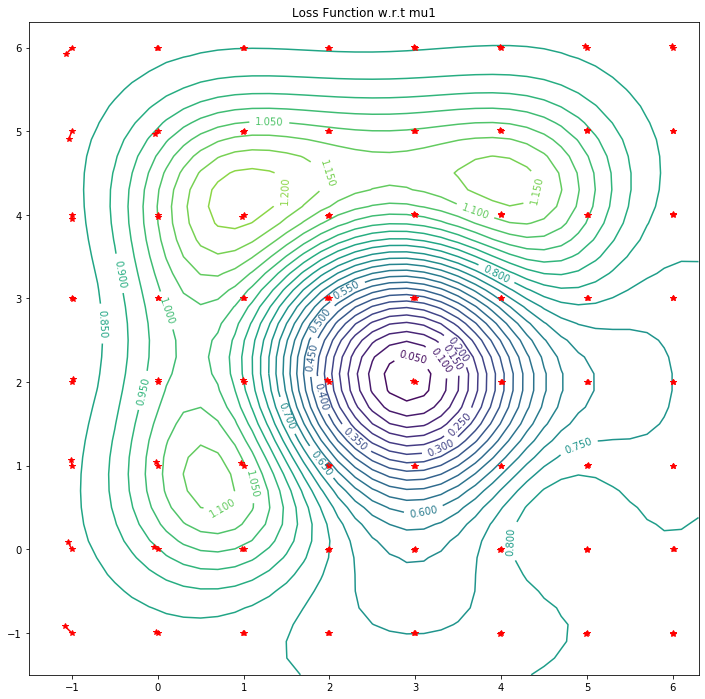

In [80]:
descent_mu1_search(X, 0.2, mu2, 0.5, 1, np.array([-1.5, 6.5]), np.array([-1.5, 6.5]))

In [10]:
w = 0.3;
p = model(X, w, mu1, mu2) -ytruth;
dpw = dpdw(X, mu1, mu2);
dpmu1 = dpdmu1(w, X, mu1);
dpmu2 = dpdmu2(w, X, mu2);
P = np.array([dpw, dpmu1[:, 0], dpmu1[:, 1], dpmu2[:, 0], dpmu2[:, 1]]);
duw = np.inner(p, dpw);
dumu1 = np.sum(np.multiply(dpmu1, p[:, np.newaxis]), axis=0);
dumu2 = np.sum(np.multiply(dpmu2, p[:, np.newaxis]), axis=0);
Q = np.array([duw, dumu1[0], dumu1[1], dumu2[0], dumu2[1]]);

In [20]:
A = discretize(31, dx, dy)
[P, grad] = gradient_all(X, 0.3, np.array([1.001, 3]), np.array([3, 2]) );
G = Gmatrix(0.3, np.array([1.001, 3]), np.array([3, 2]), X, 31, dx, dy, A, P);
G

array([[121.03458226,  -9.10580322,   6.85429375, -21.85239527,
          7.54482646],
       [ -9.10580322,   3.31293315,  -0.36920901,  -1.26206953,
          2.78371674],
       [  6.85429375,  -0.36920901,   2.7118697 ,   1.37294619,
          2.09943769],
       [-21.85239527,  -1.26206953,   1.37294619,  14.35781322,
         -0.49511615],
       [  7.54482646,   2.78371674,   2.09943769,  -0.49511615,
         14.0710265 ]])